# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [69]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [70]:
# # load in the data
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [71]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [72]:
# load all the data

azdias = pd.read_csv('azdias.csv')
customers = pd.read_csv('customers.csv')
mailout_train = pd.read_csv('mailout_train.csv')
mailout_test = pd.read_csv('mailout_test.csv')

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [73]:
print(azdias.shape)
print(customers.shape)
print(mailout_train.shape)
print(mailout_test.shape)

(891221, 367)
(191652, 370)
(42962, 368)
(42833, 367)


In [74]:
# remove first columns (Unnamed: 0)
azdias = azdias.iloc[:, 1:]
customers = customers.iloc[:, 1:]
mailout_train = mailout_train.iloc[:, 1:]
mailout_test = mailout_test.iloc[:, 1:]

# Data Exploration and ad-hoc Data Cleaning

In [75]:
# Inspect the feature descriptions
dias_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)

In [76]:
dias_info = dias_info.iloc[:, 1:]
dias_info.head(20)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


It appears that the different features are separated from each other by a number of NaNs equal to the number of non-missing categories for each feature. For example, 'ALTERSKATEGORIE_GROB' separated from 'ALTER_HH' by 5 non-missing categories.

Hence we forward-fill the 'Attribute' feature.

In [77]:
dias_info['Attribute'] = dias_info['Attribute'].fillna(method='ffill')
dias_info.head(20)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In the *Meaning* feature, there are descriptions that indicate unknown values. It seems that the corresponding values in the 'Value' column can be -1 or 0. We will confirm by filtering out all the observations that are tagged is unknown:

In [78]:
dias_info_missing = dias_info[dias_info['Meaning'].str.contains('unknown') | dias_info['Meaning'].str.contains('no')]
pd.set_option('display.max_rows', 1000)
dias_info_missing

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
49,BIP_FLAG,NaN,0,no company in the building
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
102,CAMEO_DEU_2015,NaN,9C,Afternoon Talk Show


In [79]:
# Get a dataframe of feature names and their corresponding values that represent missingness
# Note that some features in the above dataframe are reapeated twice (appear in 2 consecutive rows) so we need to handle that too

missing_token_list = []

for feature in dias_info_missing['Attribute'].unique():
    # get all the observations for the feature in the current iteration
    missing_tokens = dias_info_missing.loc[dias_info_missing['Attribute'] == feature, 'Value'].astype(str).str.cat(sep=',').split(',')
    missing_token_list.append(missing_tokens)

print(len(missing_token_list) == len(dias_info_missing.Attribute.unique()))
# get the unique features and their corresponding tokens that represent missingness
missing_df = pd.concat([pd.Series(dias_info_missing['Attribute'].unique()), pd.Series(missing_token_list)], axis=1)
missing_df.columns = ['Attributes', 'Missing_or_Unknown']
missing_df

True


,Attributes,Missing_or_Unknown
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]
5,BIP_FLAG,"[-1, 0]"
6,CAMEO_DEUG_2015,[-1]
7,CAMEO_DEU_2015,[9C]
8,CAMEO_DEUINTL_2015,[-1]
9,CJT_GESAMTTYP,[0]


In [80]:
# Get feature names that have more than 2 values in the 'Value' column to look for possible misclassification
boolean_mask = missing_df['Missing_or_Unknown'].apply(lambda x: len(x) > 2)
names_df = missing_df[boolean_mask]
names_df

,Attributes,Missing_or_Unknown
78,GEBAEUDETYP,"[-1, 0, 2, 4, 5, 6, 8]"
80,GEOSCORE_KLS7,"[-1, 0, 1]"
85,KBA05_ALTER1,"[-1, 9, 0]"
88,KBA05_ALTER4,"[-1, 9, 0]"
89,KBA05_ANHANG,"[-1, 9, 0]"
99,KBA05_CCM4,"[-1, 9, 0]"
100,KBA05_DIESEL,"[-1, 9, 0]"
103,KBA05_HERST1,"[-1, 9, 0]"
104,KBA05_HERST2,"[-1, 9, 0]"
105,KBA05_HERST3,"[-1, 9, 0]"


In [81]:
# some cleaning up
missing_df.set_index('Attributes', inplace=True)
missing_df.at['PRAEGENDE_JUGENDJAHRE', 'Missing_or_Unknown'] = [-1, 0]
missing_df.at['KBA05_MAXVORB', 'Missing_or_Unknown'] = [-1, 9]
missing_df.at['GEBAEUDETYP', 'Missing_or_Unknown'] = [-1, 0]
missing_df.at['GEOSCORE_KLS7', 'Missing_or_Unknown'] = [-1, 0]

In [83]:
missing_df

,Missing_or_Unknown
Attributes,
AGER_TYP,"[-1, 0]"
ALTERSKATEGORIE_GROB,"[-1, 0]"
ALTER_HH,[0]
ANREDE_KZ,"[-1, 0]"
BALLRAUM,[-1]
BIP_FLAG,"[-1, 0]"
CAMEO_DEUG_2015,[-1]
CAMEO_DEU_2015,[9C]
CAMEO_DEUINTL_2015,[-1]


In [84]:
unknowns = missing_df.reset_index()
unknowns.head()

,Attributes,Missing_or_Unknown
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]


In [90]:
# unknowns.loc[unknowns['Attributes'] == 'ALTER_HH', 'Missing_or_Unknown']

2    [0]
Name: Missing_or_Unknown, dtype: object

In [93]:
# Use the unknowns dataframe to identify the observations in the azdias dataframe that are missing or unknown as per the encoded values, 
#then replace them as NaNs for easier processing later

for name in unknowns['Attributes']:
    if name in azdias.columns:
        # get value of the 'Missing_or_Unknown' column for the current iteration
        missing_vals = unknowns.loc[unknowns['Attributes'] == name, 'Missing_or_Unknown'].iloc[0]
        
        # get the row indexes of the azdias dataframe that contain the missing_vals
        missing_idxs = azdias.loc[:, name].isin(missing_vals)
        
        # replace
        azdias.loc[missing_idxs, name] = np.NaN
    else:
        continue


In [94]:
# inspect summary stats of azdias dataframe
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,205378.000000,817722.000000,580954.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,743233.000000,817722.000000,791123.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,1.743410,4.421928,15.291805,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,4.147141,7.908791,4.088440,3.362438,1.522098,2.777398
std,2.572735e+05,0.674312,3.638805,3.800536,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.784211,1.923137,1.920553,1.352704,0.499512,1.068775
min,1.916530e+05,1.000000,1.000000,1.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,1.000000,1.000000,13.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,3.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,2.000000,3.000000,16.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,4.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,2.000000,9.000000,18.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [96]:
# dump the azdias and unknowns dataframes to pickle objects to free up memory
import pickle
pickle.dump(azdias, open("azdias.pickle", "wb"))
pickle.dump(unknowns, open("unknowns.pickle", "wb"))

In [98]:
# load the azdias picle object again
azdias = pickle.load(open("azdias.pickle", "rb"))

In [99]:
# Check columns 18 and 19 to confirm their datatypes, as prompted by the error above while loading the data
azdias.iloc[:, 18:20].columns.values

array(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype=object)

In [100]:
# Look at CAMEO_INTL
azdias['CAMEO_INTL_2015'].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [101]:
# Fill in NaNs and combine sparse data
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].fillna(0)

azdias['CAMEO_INTL_2015'].replace('XX', '00', inplace=True)

In [102]:
azdias['CAMEO_INTL_2015'].unique()

array([0, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', '00'],
      dtype=object)

**Taking a closer look into the data, I realized that CAMEO_DEUG_2015 has actually been factored into the CAMEO_DEU_2015 feature. The numbers in the former form represent the first digit of the variables in the latter.**

**We will consider engineering new features out of CAMEO_DEU_2015 at a later part. Till then, we fill in missing values.** 

In [103]:
azdias['CAMEO_DEU_2015'].unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '7D', '5E', '1D', '8D',
       '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F', '1C',
       'XX'], dtype=object)

In [104]:
azdias['CAMEO_DEU_2015'] = azdias['CAMEO_DEU_2015'].fillna('00')

In [105]:
azdias['CAMEO_DEU_2015'].replace('XX', '00', inplace=True)

In [106]:
# Do a check
azdias['CAMEO_DEU_2015'].unique()

array(['00', '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '7D', '5E', '1D', '8D',
       '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F', '1C'],
      dtype=object)

**Drop CAMEO_DEUG_2015, which is redundant**

In [107]:
# Drop CAMEO_DEUG_2015 since we don't need it anymore
azdias.drop(columns=['CAMEO_DEUG_2015'], axis=1, inplace=True)

**Preparation for feature engineering (CAMEO_INTL_2015)**

In [109]:
# replace '0' with '00' to prepare for feature engineering later
azdias['CAMEO_INTL_2015'].replace(0, '00', inplace=True)
azdias['CAMEO_INTL_2015'].unique()

array(['00', 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45'],
      dtype=object)

In [110]:
# convert all values to string
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].apply(lambda x: str(x))
azdias['CAMEO_INTL_2015'].unique()

array(['00', '51.0', '24.0', '12.0', '43.0', '54.0', '22.0', '14.0',
       '13.0', '15.0', '33.0', '41.0', '34.0', '55.0', '25.0', '23.0',
       '31.0', '52.0', '35.0', '45.0', '44.0', '32.0', '22', '24', '41',
       '12', '54', '51', '44', '35', '23', '25', '14', '34', '52', '55',
       '31', '32', '15', '13', '43', '33', '45'], dtype=object)

## Check for Missing Values

In this section, we attempt to check for columns with a large proportion of missing values. If the number of missing values is above a certain threshold, we remove that column.

**Handle columns**

In [111]:
# Inspect the number of missing data that each column has, and rank them in descending order
azdias.isnull().sum().sort_values(ascending=False)

ALTER_KIND4                    890016
TITEL_KZ                       889061
ALTER_KIND3                    885051
D19_TELKO_ONLINE_DATUM         883018
D19_BANKEN_OFFLINE_DATUM       871535
ALTER_KIND2                    861722
D19_TELKO_ANZ_12               857990
D19_BANKEN_ONLINE_QUOTE_12     845987
D19_BANKEN_ANZ_12              831734
D19_TELKO_ANZ_24               826208
D19_VERSI_ANZ_12               821289
D19_TELKO_OFFLINE_DATUM        819114
ALTER_KIND1                    810163
KBA05_SEG6                     802740
D19_BANKEN_ANZ_24              794100
D19_VERSI_ANZ_24               777037
KBA05_ANTG4                    733495
D19_BANKEN_ONLINE_DATUM        726982
AGER_TYP                       685843
D19_BANKEN_DATUM               678331
D19_VERSAND_ONLINE_QUOTE_12    674480
D19_TELKO_DATUM                665798
EXTSEL992                      654153
D19_GESAMT_ONLINE_QUOTE_12     650188
KBA05_ANTG3                    644869
D19_VERSAND_ANZ_12             637972
D19_VERSAND_

In [112]:
azdias.isnull().sum().describe()

count       365.000000
mean     171409.824658
std      205671.472234
min           0.000000
25%       73499.000000
50%      105800.000000
75%      191596.000000
max      890016.000000
dtype: float64

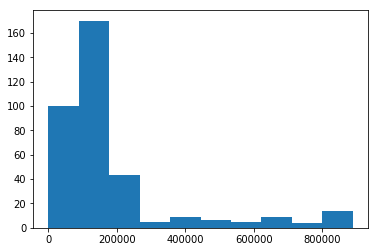

In [113]:
# Obtain a visual representation using a histogram
plt.hist(x=azdias.isnull().sum(), bins=10)
plt.show()

From the data we collected above, we can infer that **75% of the data have 191596 missing data or less**. This was visualized using the histogram plot of column counts vs missing value counts.

We will set the threshold at **200,000** missing values for deciding which columns to keep.

Columns with missing entries greater than this value will be dropped.

In [114]:
low_missing_col = azdias.isnull().sum()[azdias.isna().sum() < 200000]

In [115]:
azdias_col_cleaned = azdias[low_missing_col.index]

In [116]:
azdias_col_cleaned.shape

(891221, 279)

**Handle rows**

In [117]:
# rank rows by the number of missing data they have, in descending order
missing_rows = azdias_col_cleaned.isnull().sum(axis=1).sort_values(ascending=False)
missing_rows.describe()

count    891221.000000
mean         25.251209
std          58.281033
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         200.000000
dtype: float64

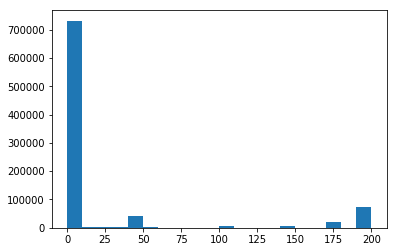

In [118]:
# plot a histogram for better visualization
plt.hist(x=missing_rows, bins=20)
plt.show()

From the data above, we can infer that more than 75% of our observations (rows) have fewer than 4 missing values. The maximum number of missing values for a row is 200.

We shall set the threshold to 25. **Observations with more than 25 missing values will be dropped**.

In [119]:
low_missing_rows = missing_rows[missing_rows < 25] 

In [121]:
azdias_cleaned_rowcol = azdias_col_cleaned.loc[low_missing_rows.index, :]

azdias_cleaned_rowcol.shape

(736395, 279)

### Categorical data exploration

In [122]:
# categorical data exploration
azdias_cleaned_rowcol.select_dtypes(include=['object']).describe()

,CAMEO_DEU_2015,CAMEO_INTL_2015,EINGEFUEGT_AM,OST_WEST_KZ
count,736395,736395,736395,736395
unique,44,43,2819,2
top,6B,51,1992-02-10 00:00:00,W
freq,53958,73154,371848,581560


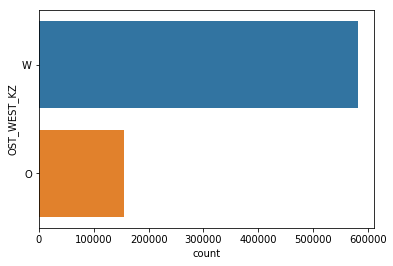

In [123]:
sns.countplot(y='OST_WEST_KZ', data=azdias_cleaned_rowcol)
plt.show()

### Numeric Data Exploration

In [124]:
azdias_cleaned_rowcol.describe()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,7.363950e+05,736395.000000,736395.000000,733070.000000,736395.000000,736395.000000,736395.000000,736395.000000,732610.000000,735920.000000,...,729241.000000,734988.000000,734988.000000,734988.000000,682164.000000,736395.000000,736378.000000,736395.000000,736395.000000,736395.000000
mean,6.376332e+05,4.404940,8.176428,0.039187,0.146112,1.738756,7.433086,0.004135,3.178293,4.142051,...,2.414499,6.004925,7.524036,5.920966,4.185464,7.965688,4.054175,3.393456,1.521152,2.818247
std,2.577280e+05,3.642443,15.110531,0.312047,0.488522,1.164092,13.615374,0.068173,0.996770,2.185798,...,1.160214,2.850069,3.259423,2.790801,1.766373,1.888459,1.896518,1.407506,0.499553,1.080924
min,1.916530e+05,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.151455e+05,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000,2.000000,...,2.000000,3.000000,5.000000,4.000000,3.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.357640e+05,3.000000,4.000000,0.000000,0.000000,1.000000,4.000000,0.000000,3.000000,5.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.622350e+05,9.000000,9.000000,0.000000,0.000000,2.000000,9.000000,0.000000,4.000000,6.000000,...,3.000000,8.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082872e+06,9.000000,536.000000,20.000000,11.000000,38.000000,375.000000,4.000000,9.000000,7.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


### Drop unwanted features

In [125]:
# these features are not relevant to our problem statement hence will be dropped
azdias_cleaned_rowcol = azdias_cleaned_rowcol.drop(['LNR', 'EINGEFUEGT_AM'], axis=1)

## Feature Engineering

In [126]:
# Create new features by splitting CAMEO_INTL_2015's variables
azdias_cleaned_rowcol['WEALTH_LEVEL'] = azdias_cleaned_rowcol['CAMEO_INTL_2015'].apply(lambda x: int(x[0]))
azdias_cleaned_rowcol['FAMILY_AGE_BAND'] = azdias_cleaned_rowcol['CAMEO_INTL_2015'].apply(lambda x: int(x[1]))

azdias_cleaned_rowcol.loc[:, ['WEALTH_LEVEL', 'FAMILY_AGE_BAND']].head()
                                                                            

,WEALTH_LEVEL,FAMILY_AGE_BAND
178425,3,4
338140,3,2
696474,2,4
687866,5,1
449098,5,1


In [127]:
# Then we can drop CAMEO_INTL_2015
azdias_cleaned_rowcol.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)

In [128]:
# check categorical data
azdias_cleaned_rowcol.select_dtypes(include=['object']).describe()

,CAMEO_DEU_2015,OST_WEST_KZ
count,736395,736395
unique,44,2
top,6B,W
freq,53958,581560


#### One-hot encoding

Create dummy variables for the categorical data. Doing so provides a binary representation of each variable in these categorical features, so that our classifier can accept them as training inputs.

In [129]:
# get dummy variables for categorical features
azdias_cleaned_rowcol = pd.get_dummies(azdias_cleaned_rowcol, columns=azdias_cleaned_rowcol.select_dtypes(include=['object']).columns.values)   

Once we are done creating dummy variables, remove the original categorical features.

In [130]:
azdias_cleaned_rowcol.drop(azdias_cleaned_rowcol.select_dtypes(include=['object']).columns.values, axis=1, inplace=True)

In [131]:
# check that the categorical features have been removed.
azdias_cleaned_rowcol.select_dtypes(include=['object']).columns.values

array([], dtype=object)

### Handle missing numeric data

Missing numerical data will be handled first by **flagging the observation with an indicator variable** of missingness- 0 for not missing, 1 for missing.

Then, **fill the original missing value with 0** just so to meet our classifier's input requirements. 

This is so that our model can **estimate the optimal constant for missingness**, instead of filling the missing values with the mean or median.

In [132]:
# Create new indicator features for columns that have missing data, and fill them up with 0 or 1
for col in azdias_cleaned_rowcol:
    if azdias_cleaned_rowcol[col].isnull().sum() > 0:
        azdias_cleaned_rowcol[f'{col}_is_missing'] = azdias_cleaned_rowcol[col].isnull().astype(int)

In [133]:
# After flagging, fill up the missing values with 0
azdias_cleaned_rowcol.fillna(0, inplace=True)

In [134]:
# check that the total sum of values in the series of missing value flags is 0 (ie no missing values)
azdias_cleaned_rowcol.isnull().sum().sum()

0

In [136]:
# use a simpler name for the dataframe
azdias_cleaned = azdias_cleaned_rowcol

## Exploring the `customers` dataset

In [137]:
# inspect new numeric feature 'ONLINE_PURCHASE'
customers['ONLINE_PURCHASE'].describe()

count    191652.000000
mean          0.090247
std           0.286536
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: ONLINE_PURCHASE, dtype: float64

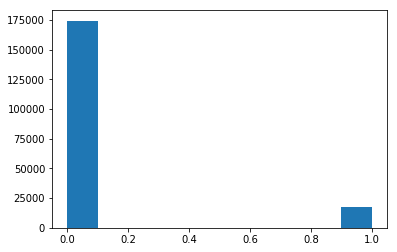

In [138]:
plt.hist(customers['ONLINE_PURCHASE'])
plt.show()

#### Check for sparse columns

In [139]:
customers.isnull().sum().sort_values(ascending=False)

ALTER_KIND4                    191416
ALTER_KIND3                    190377
ALTER_KIND2                    186552
ALTER_KIND1                    179886
KK_KUNDENTYP                   111937
EXTSEL992                       85283
KBA05_SEG7                      55980
KBA05_KW1                       55980
KBA05_SEG4                      55980
KBA05_SEG5                      55980
KBA05_SEG6                      55980
KBA05_MAXAH                     55980
KBA05_SEG8                      55980
KBA05_KW2                       55980
KBA05_VORB0                     55980
KBA05_KRSZUL                    55980
KBA05_VORB1                     55980
KBA05_KRSVAN                    55980
KBA05_KRSOBER                   55980
KBA05_SEG9                      55980
MOBI_REGIO                      55980
KBA05_KW3                       55980
KBA05_SEG3                      55980
KBA05_KRSHERST3                 55980
KBA05_MAXBJ                     55980
KBA05_MAXHERST                  55980
KBA05_MAXSEG

In [141]:
missing_cols = customers.isnull().sum().describe()
missing_cols

count       369.000000
mean      37573.230352
std       29023.125309
min           0.000000
25%           0.000000
50%       51281.000000
75%       51281.000000
max      191416.000000
dtype: float64

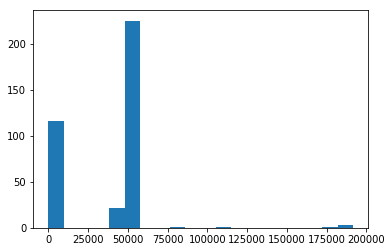

In [142]:
plt.hist(x=customers.isnull().sum(), bins=20)
plt.show()

#### Check for sparse rows

In [46]:
customers.isnull().sum(axis=1).describe()

count    191652.000000
mean         72.342172
std         107.600590
min           0.000000
25%           4.000000
50%           5.000000
75%         225.000000
max         259.000000
dtype: float64

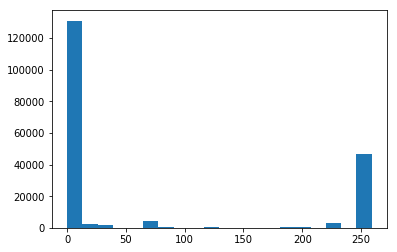

In [143]:
plt.hist(x=customers.isnull().sum(axis=1), bins=20)
plt.show()

#### Explore categorical data

In [144]:
customers.select_dtypes(include=['object']).describe()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
count,141224,141224,141224,143955,141725,141725,191652,191652
unique,45,19,43,35,3034,2,3,2
top,2D,2,14,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
freq,11208,17574,14708,31910,64744,130382,100860,132238


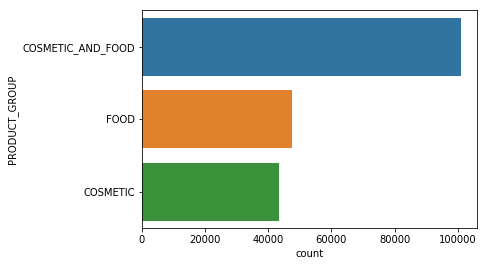

In [145]:
# count plot for product data (categorical) for illustration purposes
sns.countplot(y='PRODUCT_GROUP', data=customers)
plt.show()

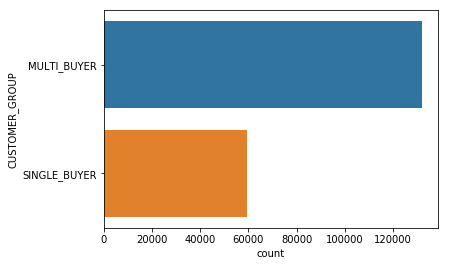

In [146]:
# count plot for CUSTOMER_GROUP feature
sns.countplot(y='CUSTOMER_GROUP', data=customers)
plt.show()

In [147]:
# explore feature with mixed datatype
customers['CAMEO_DEUG_2015'].unique()

array([1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8',
       '9', '2', '4', '1', '7', '5', 'X'], dtype=object)

### Insights
Seems that the data makeup of the `customers` dataset is similar to that of the general census data (`azdias`). Processing steps will be similar, just that the thresholds used to remove columns and rows based on missing data composition will be different.

## Data Cleaning and Engineering function

The data processing steps of cleaning and feature engineering will be encapsulated in the function below. The function will streamline these processes for the `customers` dataset.

In [148]:
# load the unknowns dataframe
unknowns = pickle.load(open("unknowns.pickle", "rb"))

In [174]:
def process_data(df, unknowns):
    
    # change the values encoded as missing/unknown to NaNs
    for name in unknowns['Attributes']:
        if name in df.columns:
            # get value of the 'Missing_or_Unknown' column for the current iteration
            missing_vals = unknowns.loc[unknowns['Attributes'] == name, 'Missing_or_Unknown'].iloc[0]

            # get the row indexes of the azdias dataframe that contain the missing_vals
            missing_idxs = df.loc[:, name].isin(missing_vals)

            # replace
            df.loc[missing_idxs, name] = np.NaN
        else:
            continue
            
    # process the CAMEO_INTL data
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].fillna('00')
    df['CAMEO_INTL_2015'] =  df['CAMEO_INTL_2015'].replace('XX', '00')
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].apply(lambda x: str(x))
    
    # process the CAMEO_DEU data
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].fillna('00')
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace('XX', '00')
    df = df.drop(columns=['CAMEO_DEUG_2015'], axis=1)
    
    # removing sparse columns
    missing_cols = df.isnull().sum()
    low_missing_cols = missing_cols[missing_cols < 52000]
    df = df[low_missing_cols.index]
    
    
    # drop unwanted features
    df = df.drop(['LNR', 'EINGEFUEGT_AM'], axis=1)
    
    # engineer new features for CAMEO_INTL
    df['WEALTH_LEVEL'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x[0]))
    df['FAMILY_AGE_BAND'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x[1]))
    # drop the original feature
    df = df.drop(['CAMEO_INTL_2015'], axis=1)
    
    # one-hot encode categorical data
    df = pd.get_dummies(df, columns=df.select_dtypes(include=['object']).columns.values)
    # remove the categorical features
    df = df.drop(df.select_dtypes(include=['object']).columns.values, axis=1)
    
    # flag and fill missing numeric data
    for col in df:
        if df[col].isnull().sum() > 0:
            df[f'{col}_is_missing'] = df[col].isnull().astype(int)
    
    df.fillna(0, inplace=True)
    
    return df
    

In [212]:
customers_cleaned = process_data(customers, unknowns)
customers_cleaned.shape

(191652, 469)

In [213]:
# some checks
customers_cleaned.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,...,UMFELD_JUNG_is_missing,UNGLEICHENN_FLAG_is_missing,VERDICHTUNGSRAUM_is_missing,VERS_TYP_is_missing,VHA_is_missing,VK_DHT4A_is_missing,VK_DISTANZ_is_missing,VK_ZG11_is_missing,WOHNDAUER_2008_is_missing,WOHNLAGE_is_missing
0,1.0,10.0,1.0,0.0,2.0,1.0,0.0,1.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0
1,9.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,0,0,0,0,1
2,1.0,0.0,1.0,0.0,1.0,1.0,0.0,3.0,7.0,2.0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,8.0,0.0,0.0,0.0,1.0,0.0,1.0,7.0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,14.0,7.0,0.0,4.0,7.0,0.0,3.0,3.0,6.0,...,0,0,0,0,0,0,0,0,0,0


In [214]:
# Some checks
customers_cleaned.describe()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,...,UMFELD_JUNG_is_missing,UNGLEICHENN_FLAG_is_missing,VERDICHTUNGSRAUM_is_missing,VERS_TYP_is_missing,VHA_is_missing,VK_DHT4A_is_missing,VK_DISTANZ_is_missing,VK_ZG11_is_missing,WOHNDAUER_2008_is_missing,WOHNLAGE_is_missing
count,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,191652.000000,191652.000000,191652.000000,191652.00000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,1.322653,7.536879,3.672213,0.103239,1.716455,3.476562,0.015434,2.080860,3.180395,3.616268,...,0.263227,0.243128,0.263373,0.25562,0.243128,0.249781,0.249781,0.249781,0.243128,0.266285
std,1.867720,5.790984,12.496959,0.433089,1.552439,12.370711,0.132730,1.517622,2.621516,1.859655,...,0.440386,0.428973,0.440464,0.43621,0.428973,0.432887,0.432887,0.432887,0.428973,0.442016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,9.000000,1.000000,0.000000,2.000000,1.000000,0.000000,2.000000,3.000000,4.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,12.000000,2.000000,0.000000,3.000000,2.000000,0.000000,3.000000,6.000000,6.000000,...,1.000000,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.000000,25.000000,523.000000,8.000000,21.000000,375.000000,5.000000,9.000000,7.000000,6.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [215]:
customers_cleaned.isnull().sum().sum()

0

In [216]:
# filter azdias to only show columns that are present in the customers dataset
common_cols = azdias_cleaned.columns[azdias_cleaned.columns.isin(customers_cleaned.columns)]

In [217]:
azdias_cleaned = azdias_cleaned[common_cols]

In [218]:
azdias_cleaned.shape

(736395, 312)

In [219]:
# do the same for the customers dataset
customers_cleaned = customers_cleaned[common_cols]

In [220]:
customers_cleaned.shape

(191652, 312)

### Normalize the Data

Now that we have cleaned up both datasets, we apply scaling transformations to our cleaned data using `MinMaxScaler()`. 

In [221]:
scaler = MinMaxScaler()

# scale the general census data
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_cleaned.astype(float)))

# rename the columns of azdias_scaled to that of the columns in azdias_cleaned 
azdias_scaled.columns = azdias_cleaned.columns

In [222]:
azdias_scaled.describe()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,...,SHOPPER_TYP_is_missing,STRUKTURTYP_is_missing,UMFELD_ALT_is_missing,UMFELD_JUNG_is_missing,VERDICHTUNGSRAUM_is_missing,VERS_TYP_is_missing,VK_DHT4A_is_missing,VK_DISTANZ_is_missing,VK_ZG11_is_missing,WOHNLAGE_is_missing
count,736395.000000,736395.000000,736395.000000,736395.000000,736395.000000,736395.000000,736395.000000,736395.000000,736395.000000,736395.000000,...,736395.000000,736395.000000,736395.000000,736395.000000,736395.000000,736395.000000,736395.000000,736395.000000,736395.000000,736395.000000
mean,0.425618,0.015255,0.013283,0.045757,0.019822,0.001034,0.351329,0.591340,0.580250,0.641121,...,0.045947,0.005140,0.004264,0.004264,0.005140,0.045947,0.001911,0.001911,0.001911,0.000023
std,0.455305,0.028191,0.044411,0.030634,0.036308,0.017043,0.113317,0.312517,0.257958,0.299111,...,0.209370,0.071509,0.065160,0.065160,0.071509,0.209370,0.043669,0.043669,0.043669,0.004805
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.003731,0.000000,0.026316,0.002667,0.000000,0.333333,0.285714,0.333333,0.400000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.250000,0.007463,0.000000,0.026316,0.010667,0.000000,0.333333,0.714286,0.666667,0.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.016791,0.000000,0.052632,0.024000,0.000000,0.444444,0.857143,0.833333,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [223]:
# perform scaling for the customers
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_cleaned.astype(float)))
customers_scaled.columns = customers_cleaned.columns

# Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Data Modeling

Clustering algorithms like K-Means rely on finding clusters in an n-dimensional feature space. For high-dimensional datasets such as ours', the clustering algorithm might **face difficulty determining the more important features, thus resulting in noisier clusters.**

Some dimensions have less importance compared to others. For egs, if every population is entirely made up of wealthy people, then this feature that measures wealth has not much significance; it will not help to separate our dataset into clusters based on wealth, because the value *does not vary*.

Instead, we want to **find features that explain the most variance** in the dataset. 

Therefore, we apply **Principal Component Analysis** to reduce dimensionality by combining existing features together to form *principal components* that are **linearly independent of each other and captures the most variance.** Hence, resulting in a denser, new feature set.

## Dimensionality Reduction using SkLearn's PCA

PCA attempts to reduce the number of features within a dataset while retaining the “principal components”, which are defined as **weighted, linear combinations of existing features** that are designed to be **linearly independent** and account for the **largest possible variability in the data**. It can be thought of as taking many features and combining similar or redundant features together to **form a new, smaller feature set**.

## Train the PCA Model

We fit the PCA model with the scaled general population data and generate the predicted principal components as a numpy array.

In [158]:
from sklearn.decomposition import PCA

In [224]:
pca = PCA(random_state=42)
azdias_pca = pca.fit_transform(azdias_scaled)

## Accessing the PCA Model Attributes

After training the model, we can access its underlying parameters.

### PCA Model Attributes

Three types of model attributes are contained within the PCA model.

  * `mean`: The mean that was subtracted from a component in order to center it.
  * `components_`: The features that make up each of the principal components.
  * `explained_variance_ratio_`: Provides the percentage of the total data's variance captured by each of the generated principal components.
  
We are only interested in `components_` and `explained_variance_ratio_`.

### Finding the maximum number of components needed to capture the most variance

In [225]:
num_components = len(pca.explained_variance_ratio_)

# get the array of percentages from the fit pca object
vals = pca.explained_variance_ratio_

# get the array of cumulative captured variance
cumvals = np.cumsum(vals)

In practice, we can aim for a number of principal components that can capture **80-90% variance.**

From trial-and-error, we can see that the **top 80 principal components** for the pca-transformed azdias dataset accounts for **81%** of our total variance. 

In [234]:
# trial and error
top_n_components = 80

# get the cumulative variance from the top n components
captured_variance = cumvals[top_n_components]

print(f"The top {top_n_components} principal components captured {captured_variance} of the total variance.")

The top 80 principal components captured 0.8001282066747832 of the total variance.


### Discussion: Dimensionality reduction

The **top 110 principal components captured about 81% of the total variance**. 

Hence we refit the PCA instance and perform the transformation using the decided number of principal components.

In [235]:
%%time
pca = PCA(n_components=80, random_state=42)
# get the transformed data matrix with the decided number of components
azdias_pca = pca.fit_transform(azdias_scaled)

CPU times: user 1min 6s, sys: 11.7 s, total: 1min 18s
Wall time: 30.7 s


In [236]:
def display_component_sklearn(pca, features_list, component_num, n_weights=10):

    v_1 = list(pca.components_[component_num])

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    
    top_10_features = list(sorted_weight_data.features[:10])
    
    plt.show()

    return top_10_features

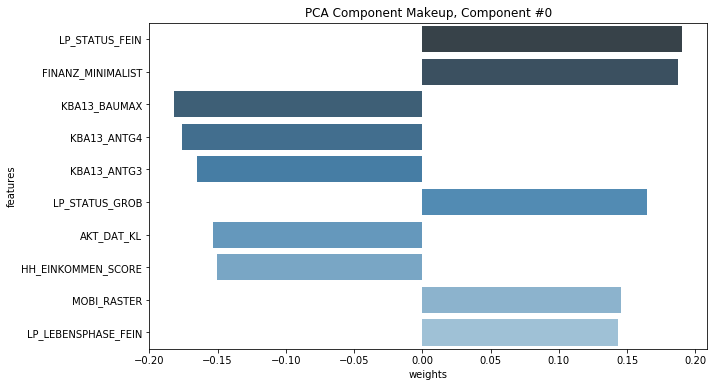

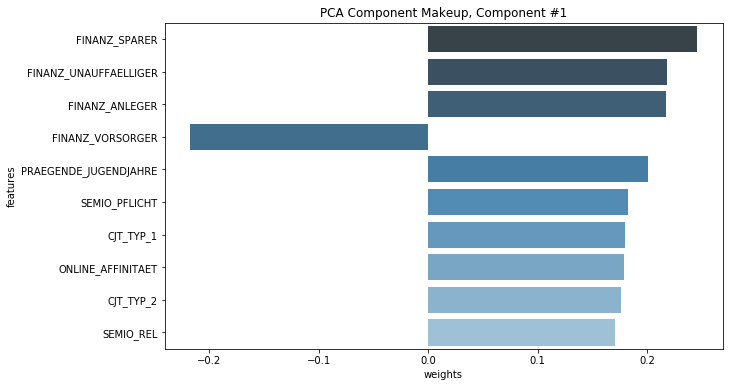

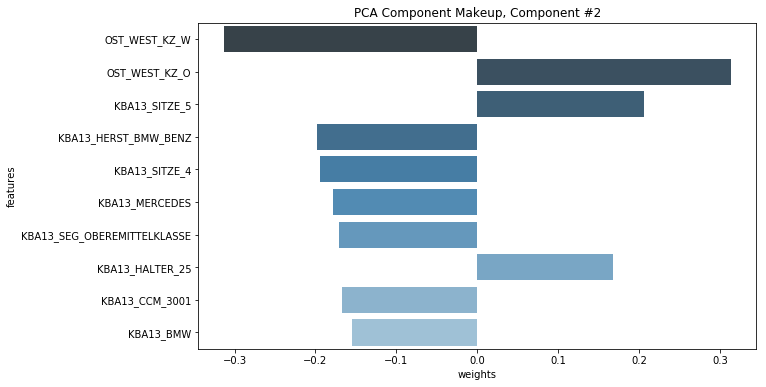

In [237]:
# In sklearn, components_ are sorted by explained_variance, in descending order (i.e. the 1st component captures the most variance)
for i in range(3):
    nth_pc = i
    features_list = azdias_scaled.columns.values
    top_features = display_component_sklearn(pca, features_list, component_num=nth_pc)

### Discussion: Intepretation of principal components

The plots above show the corresponding weights of the top 10 features in each of the principal components. The weights plots of the top 3 components are shown.

Note that the features within each principal component is not independent on each other; only the principal components themselves are independent of each other.

  * 1st Principal Component: positively correlated with 'fine social status', the number of 1-2 families within a cell, number of buildings in a cell, mobility, and 'rough social status'. Negatively correlated with the features 'most common building type', number of >10 family houses in the KBA13, number of >10 family houses in the PLZ8, number of 6-10 family houses in the KBA13 and PLZ8
  
  *  2nd Principal Component: Positively correlated features are 'money savers', 'investors', 'dominating movement in the person's youth (avatgarde or mainstream)', 'online affinity', 'financially unremarkable', 'customer journey typo9logy relating to the preferred information and buying channels', 'whether the person is social'. Negatively correlated with features 'minimalists', and a certain type of CJT
  
  *  3rd Principal component: Positively correlated with features 'former affinity with east germany', 'number of cars with 5 seats is KBA13', and negatively correlated with the features 'former affinity with west germany', 'share of BMW and mercedes benz in the KBA13', 'share of cars with >3001 cc in the KBA13', 'share of mercedes in the kba13', 'number of cars with 4 seats', 'share of upper and middle class cars in the KBA13', 'share of cars in the KBA13 with greater than 211 max speed'.
  
The values of the principal components can be positively or negatively correlated with the features that make it up. For example, PC0 will have a higher value if 'LP_STATUS_FEIN' is higher, or have a lower value if 'KBA13_ANTG3' has a higher value.

We can also infer the theme of the principal component. For example, PC0 seems to draw relationships between building types and family sizes. PC1 seems to draw relationships between financial status and mindsets. PC2 seems to draw relationships between car types and former political affiliations. 

# Population Segmentation

We shall use the k-Means unsupervised clustering algorithm to segment the customers and general population using their PCA attributes.

k-Means is a clustering algorithm that identifies clusters of similar data points based on their component makeup.

## Choosing 'k'

A good 'k' will be one such that the data points in a single cluster are close together but there are enough clusters to effectively separate the data. A bad 'k' will be one that results in very few data points being close to the cluster centers, or one that results in data points being too far away from the cluster centers.

We will select a k such that the data points in a single cluster are close together but there are enough clusters to effectively separate the data.

This can be done by measuring how close our data points are to each cluster, and the average centroid distance between cluster points and a centroid.

After trying several values of k, the centroid distance typically reaches some 'elbow'; it stops decreasing at a sharp rate and this indicates a good value of k.

# Predicting using SkLearn's KMeans

We will use sklearn's `KMeans` class to perform k-means clustering on the PCA-transformed data.

The KMeans' `.score()` method will give the average distance from each point to its assigned cluster's center.

In [238]:
from sklearn.cluster import KMeans, MiniBatchKMeans

kmeans_scores = []

for i in range(2, 21, 1):
    kmeans = MiniBatchKMeans(i)
    kmeans.fit(azdias_pca)
    score = np.abs(kmeans.score(azdias_pca))
    print(f'For {i} clusters, average point-to-centroid distances = {score}')
    kmeans_scores.append(score)

For 2 clusters, average point-to-centroid distances = 9879038.935230358
For 3 clusters, average point-to-centroid distances = 9398832.272173181
For 4 clusters, average point-to-centroid distances = 9131823.442036273
For 5 clusters, average point-to-centroid distances = 8878671.83982394
For 6 clusters, average point-to-centroid distances = 8926796.758956425
For 7 clusters, average point-to-centroid distances = 8509113.27823613
For 8 clusters, average point-to-centroid distances = 8380791.245073223
For 9 clusters, average point-to-centroid distances = 8460792.703592159
For 10 clusters, average point-to-centroid distances = 8162809.199486273
For 11 clusters, average point-to-centroid distances = 8017718.418774933
For 12 clusters, average point-to-centroid distances = 8101468.667250356
For 13 clusters, average point-to-centroid distances = 7977779.466194913
For 14 clusters, average point-to-centroid distances = 7788920.305504007
For 15 clusters, average point-to-centroid distances = 776073

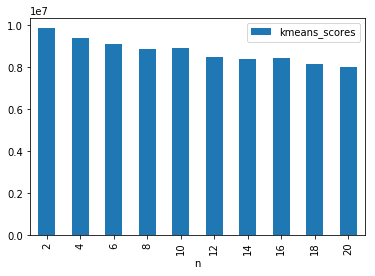

In [240]:
# plot a graph to visualize the change in intra-cluster distance across the different cluster number parameters
n = list(range(2, 22, 2))
cluster_df = pd.DataFrame(list(zip(kmeans_scores, n)))
# name the columns
cluster_df.columns = ['kmeans_scores', 'n']
# cluster_df.set_axis(['kmeans_scores', 'n'], axis=1, inplace=True)
cluster_df.plot.bar(x='n', y='kmeans_scores')

### Discussion: Number of k-clusters to choose for efficient segmentation of the general population 

Chose **12 clusters** to segment the population, since after 12 clusters, the **rate of decrease in the avg distance is smaller**. Hence the additional benefit from using additional clusters beyond this point is smaller as per the law of diminishing returns.

In [241]:
%%time
# refit the kmeans model with the selected number of clusters, then cluster the predictions for the general pop
kmeans = MiniBatchKMeans(n_clusters=12, random_state=42)
clusters_azdias = kmeans.fit_predict(azdias_pca) # feed in the object returned by pca.fit_transform, which is a nd.numpy array

CPU times: user 7.43 s, sys: 386 ms, total: 7.82 s
Wall time: 7.43 s


## PCA-transform and cluster the customer data

Here, we clean and scale the customer dataset, before using the PCA model (trained with the general population data) to generate principal components, thereafter applying the KMeans model to cluster these components.

**DO NOT FIT** THE PCA MODEL WITH THE CUSTOMERS DATASET! (hence use `.transform()` instead of `.fit_transform()` for pca, and use `.predict()` instead of `.fit_predict()` for kmeans)

In [242]:
%%time
# get the pca-transformed data matrix for the customers dataset, using the pca object fit on the general population data
customers_pca = pca.transform(customers_scaled)

# cluster predictions for the customers' pca-transformed data, by using the kmeans model fit on the general population data  
clusters_cust = kmeans.predict(customers_pca)

CPU times: user 1.78 s, sys: 332 ms, total: 2.11 s
Wall time: 1.21 s


# Comparing Customer Clusters to General Population Clusters

We make comparisons between the proportion of persons in each cluster for the general population, and the proportion of persons in each cluster for the customers population.

For example, if a cluster represents about 10% of the total general population, and the same cluster representing 20% of the total customers population (20% of customer data closest to that centroid), this means that people in this cluster have characteristics that make them a target audience for the client's product.

Likewise, if the cluster represents about 10% of the total population, and 5% of the customer population, this means that these people are not the target audience.

We will use Seaborn's `.barplot()` and `.countplot()` functions to visualize the comparison between the customer and general population clusters.

We will look for over-representation and/or under-representations by the customers dataset in each of the clusters, and interpret the principal components that lie in these clusters to infer the characteristics of the customers. We can also use `.inverse_transform()` method of the PCA and MinMaxScaler objects to transform the centroids back to the original data space and interpret the retrieved values directly.

**Inspecting the array of cluster values for each population**

In [243]:
# for the general population
clusters_azdias_df = pd.DataFrame(clusters_azdias, columns=['Cluster'])

In [244]:
clusters_azdias_df.head()

,Cluster
0,11
1,2
2,5
3,10
4,10


In [245]:
# for the customer population
clusters_cust_df = pd.DataFrame(clusters_cust, columns=['Cluster'])
clusters_cust_df.head()

,Cluster
0,7
1,0
2,4
3,7
4,5


In [246]:
# get number of clusters
num_clusters = len(clusters_azdias_df['Cluster'].unique())
num_clusters

12

#### Comparing proportion of data in each of the 8 clusters between the two datasets

In [250]:
azdias_prop = []
cust_prop = []

for i in range(num_clusters):
   
    azdias_prop_i = len(clusters_azdias_df[clusters_azdias_df['Cluster'] == i]) / len(clusters_azdias_df) * 100
    cust_prop_i = len(clusters_cust_df[clusters_cust_df['Cluster'] == i]) / len(clusters_cust_df) * 100

    azdias_prop.append(azdias_prop_i)
    cust_prop.append(cust_prop_i)
    

cluster_list = list(range(0, num_clusters))
prop_df = pd.DataFrame(list(zip(cluster_list, azdias_prop, cust_prop)), columns=['cluster', 'azdias_prop_%', 'cust_prop_%'])

prop_df
        

,cluster,azdias_prop_%,cust_prop_%
0,0,11.811596,4.579655
1,1,10.699285,0.689792
2,2,7.835605,9.893453
3,3,9.178770,1.111389
4,4,8.804785,12.663056
5,5,8.598918,5.009601
6,6,6.376605,0.329764
7,7,10.158271,34.984242
8,8,4.038458,25.077223
9,9,7.869554,2.612548


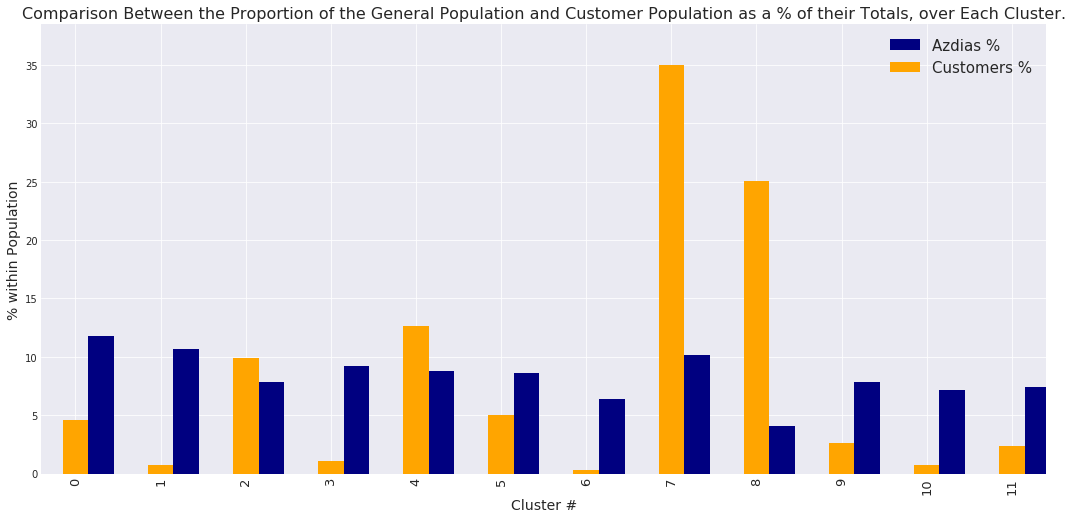

In [251]:
# Visualize with a graph
sns.set_style('darkgrid')

fig = plt.figure(figsize=(18, 8))

ax = fig.add_subplot(111)

ax = prop_df['azdias_prop_%'].plot(x=prop_df['cluster'], 
                                      kind='bar',
                                      color='navy', 
                                      width=0.3, 
                                      align='edge',
                                      position=0)

ax = prop_df['cust_prop_%'].plot(x=prop_df['cluster'], 
                                      kind='bar',
                                      color='orange', 
                                      width=0.3, 
                                      align='edge',
                                      position=1)

ax.margins(x=0.5, y=0.1)
ax.set_xlabel('Cluster #', fontsize=14)
ax.set_ylabel('% within Population', fontsize=14)
ax.xaxis.set(ticklabels=cluster_list)
ax.tick_params(axis='x', which='major', labelsize=13)
plt.xticks(rotation=90,)


plt.legend(('Azdias %', 'Customers %'),fontsize=15)
plt.title(('Comparison Between the Proportion of the General Population and Customer Population as a % of their Totals, over Each Cluster.')
          ,fontsize=16)

plt.subplots_adjust(bottom=0.1)
plt.show()

### Analysis of Clusters (Principal Components)

Clusters **7** and **8** are over-represented by customers

Clusters **1** and **3** have obvious under-representation.
 
We will dive into the makeup of the principal components present in these clusters to infer the characteristics of the client's customers / non-customers.

**First**, we find the principal component that contains the most relevance for each of these clusters by analyzing the cluster centers using `cluster_centers_`.



In [252]:
len(kmeans.cluster_centers_)

12

Each cluster center contains 80 values (dimensions). These correspond to the 80 principle components that we used to fit the kmeans model.

In [253]:
len(kmeans.cluster_centers_[0])

80

#### For clusters with customer over-representations

In [255]:
# for cluster 7
cc7 = kmeans.cluster_centers_[7]
cc7 = pd.DataFrame(cc7, columns=['c'])
cc7 = cc7['c'].sort_values(ascending=False)
cc7.head()

0     1.743791
4     0.830642
3     0.236083
8     0.102511
10    0.092834
Name: c, dtype: float64

In [256]:
# for cluster 8
cc8 = kmeans.cluster_centers_[8]
cc8 = pd.DataFrame(cc8, columns=['c'])
cc8 = cc8['c'].sort_values(ascending=False)
cc8.head()

7     2.208754
10    0.625871
12    0.410505
21    0.282547
9     0.204100
Name: c, dtype: float64

#### For clusters with under-representation of customers

In [257]:
# for cluster 1 (under-rep)
cc1 = kmeans.cluster_centers_[1]
cc1 = pd.DataFrame(cc1, columns=['c'])
cc1 = cc1['c'].sort_values(ascending=False)
cc1.head()

1     1.038831
6     0.190183
5     0.084831
18    0.075298
47    0.048222
Name: c, dtype: float64

In [258]:
# for cluster 3 (under-rep)
cc3 = kmeans.cluster_centers_[3]
cc3 = pd.DataFrame(cc3, columns=['c'])
cc3 = cc3['c'].sort_values(ascending=False)
cc3.head()

1     1.175466
4     1.076162
6     0.219321
56    0.064589
53    0.052499
Name: c, dtype: float64

In [84]:
# for cluster 1 (under-rep)
cc1 = kmeans.cluster_centers_[1]
cc1 = pd.DataFrame(cc1, columns=['c'])
cc1 = cc1['c'].sort_values(ascending=False)
cc1.head()

2     1.627908
1     0.421432
8     0.281701
3     0.127585
11    0.092342
Name: c, dtype: float64

#### Inference

**Top 2 PCs for strong customer rep**
  * Cluster 7: PC0 / PC4
  * Cluster 8: PC7 / PC10
  
**Top PCs for weak customer rep**
  * Cluster 1: PC1 / PC2
  * Cluster 3: PC1 / PC4

### Analysis of Clusters Part 2 (Feature weights)

Now, we find the features that carry the most **weight** (positive and negative) for each of these principal components.

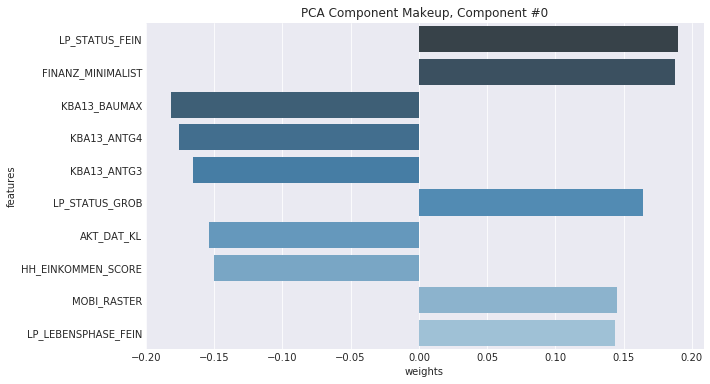

In [259]:
# For strong customer reps
nth_pc = 0
top_10_features_pc0 = display_component_sklearn(pca, features_list, component_num=nth_pc)

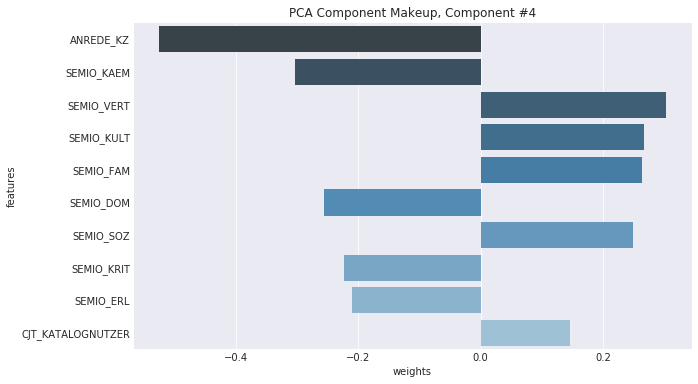

In [260]:
nth_pc = 4
top_10_features_pc4 = display_component_sklearn(pca, features_list, component_num=nth_pc)

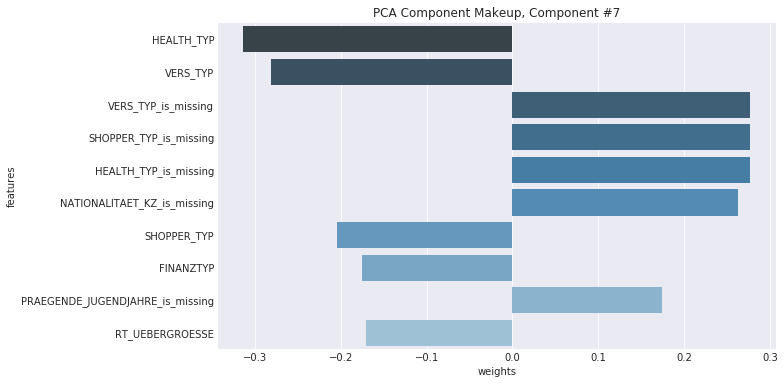

In [261]:
nth_pc = 7
top_10_features_pc7 = display_component_sklearn(pca, features_list, component_num=nth_pc)

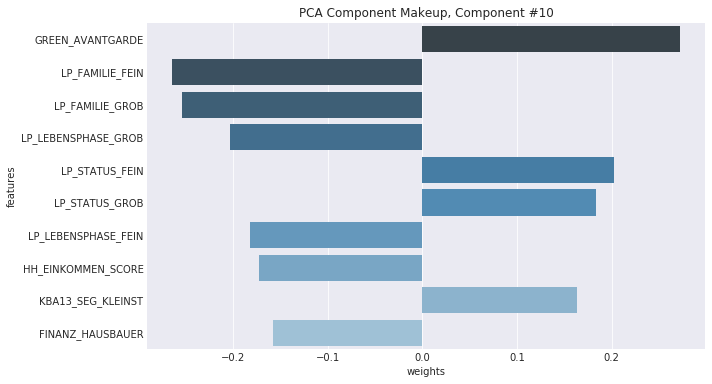

In [262]:
nth_pc = 10
top_10_features_pc10 = display_component_sklearn(pca, features_list, component_num=nth_pc)

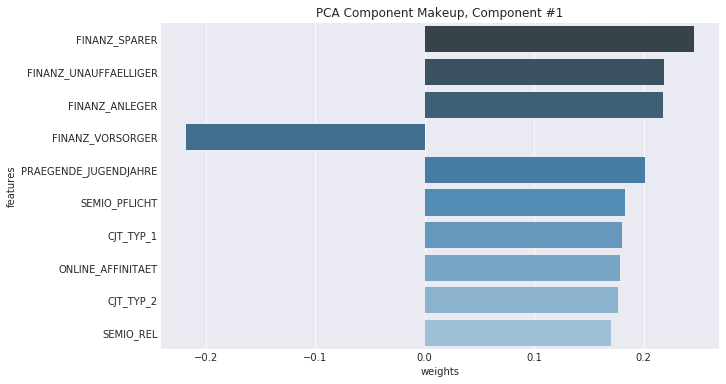

In [263]:
nth_pc = 1
top_10_features_pc1 = display_component_sklearn(pca, features_list, component_num=nth_pc)

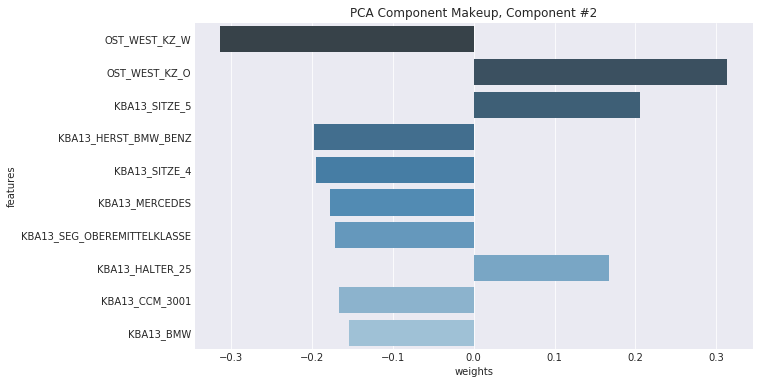

In [264]:
nth_pc = 2
top_10_features_pc2 = display_component_sklearn(pca, features_list, component_num=nth_pc)

### Get original feature values in each cluster centroid

In [265]:
# for strong reps

# transform cluster 7 to original feature values
customer_over_rep7 = scaler.inverse_transform(pca.inverse_transform(cc7).reshape(1, -1))
customer_over_rep7 = pd.Series(customer_over_rep7.squeeze()).round(2)
customer_over_rep7.index = features_list

# transform cluster 8
customer_over_rep8 = scaler.inverse_transform(pca.inverse_transform(cc8).reshape(1, -1))
customer_over_rep8 = pd.Series(customer_over_rep8.squeeze()).round(2)
customer_over_rep8.index = features_list

In [266]:
# For weak reps

# transform cluster 1
customer_under_rep1 = scaler.inverse_transform(pca.inverse_transform(cc1).reshape(1, -1))
customer_under_rep1 = pd.Series(customer_under_rep1.squeeze()).round(2)
customer_under_rep1.index = features_list

# transform cluster 3
customer_under_rep3 = scaler.inverse_transform(pca.inverse_transform(cc3).reshape(1, -1))
customer_under_rep3 = pd.Series(customer_under_rep3.squeeze()).round(2)
customer_under_rep3.index = features_list

**Strong reps**

In [267]:
# Show the values of the top features in the top principal components of the clusters

# PC0 in cluster 7
customer_over_rep7[top_10_features_pc0]

LP_STATUS_FEIN          8.43
FINANZ_MINIMALIST       4.09
KBA13_BAUMAX           -0.46
KBA13_ANTG4             0.02
KBA13_ANTG3             0.65
LP_STATUS_GROB          3.96
AKT_DAT_KL              1.50
HH_EINKOMMEN_SCORE      2.40
MOBI_RASTER             3.31
LP_LEBENSPHASE_FEIN    28.53
dtype: float64

In [268]:
# PC4 in cluster 7
customer_over_rep7[top_10_features_pc4]

ANREDE_KZ            1.40
SEMIO_KAEM           3.61
SEMIO_VERT           4.82
SEMIO_KULT           4.58
SEMIO_FAM            4.21
SEMIO_DOM            4.33
SEMIO_SOZ            4.07
SEMIO_KRIT           3.78
SEMIO_ERL            4.31
CJT_KATALOGNUTZER    2.50
dtype: float64

In [269]:
# PC7 in cluster 8
customer_over_rep8[top_10_features_pc7]

HEALTH_TYP                          2.38
VERS_TYP                            1.56
VERS_TYP_is_missing                 0.06
SHOPPER_TYP_is_missing              0.06
HEALTH_TYP_is_missing               0.06
NATIONALITAET_KZ_is_missing         0.07
SHOPPER_TYP                         1.72
FINANZTYP                           4.50
PRAEGENDE_JUGENDJAHRE_is_missing    0.06
RT_UEBERGROESSE                     4.13
dtype: float64

In [270]:
# PC10 in cluster 8
customer_over_rep8[top_10_features_pc10]

GREEN_AVANTGARDE        0.51
LP_FAMILIE_FEIN         8.36
LP_FAMILIE_GROB         4.31
LP_LEBENSPHASE_GROB     9.81
LP_STATUS_FEIN         10.52
LP_STATUS_GROB          4.84
LP_LEBENSPHASE_FEIN    32.84
HH_EINKOMMEN_SCORE      2.22
KBA13_SEG_KLEINST       2.76
FINANZ_HAUSBAUER        2.14
dtype: float64

**Weak reps**

In [271]:
# PC2 in cluster 1
customer_under_rep1[top_10_features_pc2]

OST_WEST_KZ_W                  0.74
OST_WEST_KZ_O                  0.26
KBA13_SITZE_5                  2.24
KBA13_HERST_BMW_BENZ           2.58
KBA13_SITZE_4                  2.62
KBA13_MERCEDES                 2.53
KBA13_SEG_OBEREMITTELKLASSE    2.73
KBA13_HALTER_25                2.15
KBA13_CCM_3001                 1.02
KBA13_BMW                      2.78
dtype: float64

In [272]:
# PC1 in cluster 1
customer_under_rep1[top_10_features_pc1]

FINANZ_SPARER            2.18
FINANZ_UNAUFFAELLIGER    1.89
FINANZ_ANLEGER           2.93
FINANZ_VORSORGER         4.07
PRAEGENDE_JUGENDJAHRE    8.30
SEMIO_PFLICHT            4.47
CJT_TYP_1                3.35
ONLINE_AFFINITAET        3.12
CJT_TYP_2                3.06
SEMIO_REL                3.99
dtype: float64

In [273]:
# PC1 in cluster 3
customer_under_rep3[top_10_features_pc1]

FINANZ_SPARER             3.13
FINANZ_UNAUFFAELLIGER     2.95
FINANZ_ANLEGER            3.62
FINANZ_VORSORGER          3.03
PRAEGENDE_JUGENDJAHRE    10.96
SEMIO_PFLICHT             4.95
CJT_TYP_1                 3.79
ONLINE_AFFINITAET         4.06
CJT_TYP_2                 3.46
SEMIO_REL                 4.71
dtype: float64

In [274]:
# PC4 in cluster 3
customer_under_rep3[top_10_features_pc4]

ANREDE_KZ            1.40
SEMIO_KAEM           3.65
SEMIO_VERT           4.53
SEMIO_KULT           4.93
SEMIO_FAM            4.47
SEMIO_DOM            4.60
SEMIO_SOZ            3.63
SEMIO_KRIT           3.60
SEMIO_ERL            3.97
CJT_KATALOGNUTZER    2.24
dtype: float64

### Discussion: Comparison of General Population and Customer Representation in the Clusters 

For the clusters with under-representation of customers, they are **cluster 1**, **cluster 3** .

for the clusters with over-representation of customers, they are **cluster 7** and **cluster 8**
 

By analyzing the original values of the features in the top principal components that make up these cluster's centroids (by applying inverse transformation to the principal components), we can determine the most important features by weight.

For the strong clusters,  the main principal components are PC0, PC4, PC7, PC10.

For the weak clusters, the main principal components are PC1, PC2, PC4.


**Cluster 7 for customer attributes:**
Top features of PC0 and their original values:
  * LP_STATUS_FEIN: *8.43*  --- younger houseowners
  * FINANZ_MINIMALIST: *4.09*  --- most people are concerned with financial matters
  * KBA13_BAUMAX:  *-0.46*   --- mainly 1-2 family homes
  * KBA13_ANTG4:  *0.02*  --- no >10 family homes
  * KBA13_ANTG3:  *0.65* --- no >6-10 family homes
  * LP_STATUS_GROB: *3.96*  --- average income earners
  * AKT_DAT_KL: *1.5* --- *unknown attribute, not described*
  * HH_EINKOMMEN_SCORE: *2.4* --- very high estimated net household income
  * MOBI_RASTER: *3.31* --- middle/low levels of mobility
  * LP_LEBENSPHASE_FEIN: *28.53* ---  top earner families
  
Top features of PC4 and their original values:
  * ANREDE_KZ: 1.4 --- male 
  * SEMIO_KAEM: 3.61 --- high/average aggression
  * SEMIO_VERT: 4.82 --- practical
  * SEMIO_KULT: 4.58 --- not very culturally inclined
  * SEMIO_FAM: 4.21 --- average family-oriented
  * SEMIO_DOM: 4.33 --- not very dominant
  * SEMIO_SOZ: 4.07 --- average social-minded
  * SEMIO_KRIT: 3.78 --- average crtically minded
  * SEMIO_ERL: 4.31 --- average eventful oriented
  * CJT_KATALOGNUTZER: *2.5* --- *unknown attribute, not described*
  
**Cluster 8 for customer attributes**
Top features of PC 7 and their original values (features for flagging missing values will be ignored):
  * HEALTH_TYP: 2.38 --- very sanitary
  * VERS_TYP: 1.56 --- individualistic; accepts risks
  * SHOPPER_TYP: 1.72 --- family shopper
  * FINANZ_TYP: 4.5 --- investor
  * RT_UEBERGROESSE: 4.13 --- *no info*
  
Top features of PC10 and their original values
  * GREEN_AVANTGARDE: 0.51 --- mixed views towards being environmentally friendly
  * LP_FAMILIE_FEIN: 8.36 --- family with older child
  * LP_FAMILIE_GROB: 4.31 --- single parents
  * LP_LEBENSPHASE_GROB: 9.81 --- low income and average earners of higher age from multi-person households
  * LP_STATUS_FEIN: 10.52 --- top earners
  * LP_STATUS_GROB: 4.84 --- average earners
  * LP_LEBENSPHASE_FEIN: 32.84 --- independent persons of younger age from multiperson households
  * HH_EINKOMMEN_SCORE: 2.22 --- very high estimated household income
  * KBA13_SEG_KLEINST: 2.76 --- average share of very small cars
  * FINANZ_HAUSBAUER: 2.14 --- high-priced homes

**Cluster 1 for non-customer attributes**
  
Top features for PC1 and their original values:
  * FINANZ_SPARER:*2.18* --- high tendency to save
  * FINANZ_UNAUFFAELLIGER: *1.89* --- very high percentage of people with unremarkable financial status
  * FINANZ_ANLEGER: investor; *2.93* --- average tendency to invest
  * FINANZ_VORSORGER: *4.07* --- low financial preparedness
  * PRAEGENDE_JUGENDJAHRE: *8.3* 
  * SEMIO_PFLICHT:*4.47* -- average/low percentage of people with traditional mindsets
  * CJT_TYP_1:  *3.35* --- does not yield to advertising
  * ONLINE_AFFINITAET: *3.12* --- high online presence
  * CJT_TYP_2: buying typology; *3.06* --- store shoppers
  * SEMIO_REL: *3.99* --- not religious
  
  
Top features for PC2 in cluster 1
  * OST_WEST_KZ_W: 0.74 --- Stay in West Germany
  * OST_WEST_KZ_O: 0.26 --- does not stay in East Germany
  * KBA13_SITZE_5: 2.24 --- low concentration of cars with 5 seats
  * KBA13_HERST_BMW_BENZ: 2.58 --- low concentration of BMW and Mercs
  * KBA13_SITZE_4: 2.62 --- low concentration of cars with 4 seats
  * KBA13_MERCEDES: 2.53 --- low concentration of mercedes
  * KBA13_SEG_OBEREMITTELKLASSE: 2.73 --- low share of middle class cars
  * KBA13_HALTER_25: 2.15 --- low share of car owners between 21 and 25
  * KBA13_CCM_3001: 1.02 --- very low concentration of cars of 3L capacity and above
  * KBA13_BMW: 2.78 --- low/average share of bmw
  

**Cluster 3 for non-customer attributes**
Top features for PC1 in cluster 3:
  * FINANZ_SPARER:*3.13* --- average tendency to save
  * FINANZ_UNAUFFAELLIGER: *2.95* --- average percentage of people with unremarkable financial status
  * FINANZ_ANLEGER: investor; *3.62* --- low tendency to invest
  * FINANZ_VORSORGER: *3.03* --- average financial preparedness
  * PRAEGENDE_JUGENDJAHRE: *10.96* 
  * SEMIO_PFLICHT:*4.95* -- low percentage of people with traditional mindsets
  * CJT_TYP_1:  *3.79* --- does not yield to advertising
  * ONLINE_AFFINITAET: *4.06* --- high online presence
  * CJT_TYP_2: buying typology; *3.46* --- store shoppers
  * SEMIO_REL: *4.71* --- not religious

Top features for PC4 in cluster 3:
  * ANREDE_KZ: 1.4 --- male 
  * SEMIO_KAEM: 3.65 --- high/average aggression
  * SEMIO_VERT: 4.53 --- practical
  * SEMIO_KULT: 4.93 --- not very culturally inclined
  * SEMIO_FAM: 4.47 --- average family-oriented
  * SEMIO_DOM: 4.6 --- not very dominant
  * SEMIO_SOZ: 3.63 --- average social-minded
  * SEMIO_KRIT: 3.6 --- average crtically minded
  * SEMIO_ERL: 3.97 --- average eventful oriented
  * CJT_KATALOGNUTZER: *2.24* --- *unknown attribute, not described*
  

  
  
### Inference

**Customer** attributes: 
  * High/average income earners who are new houseowners, staying in a urban, sanitary, densely populated area with a high percentage of 1-2 family homes
  * Homes in the area are priced high
  * Young couples / singles with children
  * Low mobility; don't move around much
  * Good financial attitudes; investors
 
**Non-customer** attributes:
  * Quite conservative with spending; high tendency to save
  * Mostly shop in stores, but spend quite a bit of time online too
  * Stay in the poorer parts of West Germany
  * Population with low/average numbers of luxury cars
  * Not religious or traditional; could be younger generation  
  
  
In essence, the client's **target audience** are **young families** who **own homes** in a **densely-populated middle/upper-class area**. They are **financially well-to-do**.

**People who do not buy from the client** are typically those who are more **conservative** with their spending, possibly from the younger generation, **cannot afford luxury cars**, and prefer to **shop in brick and mortar stores**.
  

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

## Exploratory Data Analysis

In [275]:
mailout_train.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,42962.000000,42962.000000,35993.000000,35993.000000,1988.000000,756.000000,174.000000,41.000000,34807.000000,35185.000000,...,35695.000000,35695.000000,35695.000000,33284.000000,35993.000000,35185.000000,42962.000000,42962.000000,42962.000000,42962.000000
mean,42803.120129,0.542922,1.525241,10.285556,12.606137,13.783069,14.655172,14.195122,9.855058,6.706096,...,4.318644,4.505953,3.116963,4.488403,8.729947,4.059685,2.804199,0.012383,1.595084,3.213910
std,24778.339984,1.412924,1.741500,6.082610,3.924976,3.065817,2.615329,3.034959,4.373539,15.151790,...,3.165199,3.289502,2.534331,1.889573,1.010545,2.046697,1.121585,0.110589,0.490881,1.067475
min,1.000000,-1.000000,1.000000,0.000000,2.000000,5.000000,6.000000,6.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,21284.250000,-1.000000,1.000000,8.000000,9.000000,12.000000,13.000000,13.000000,8.000000,1.000000,...,1.000000,2.000000,1.000000,3.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
50%,42710.000000,1.000000,1.000000,10.000000,13.000000,14.000000,15.000000,15.000000,10.000000,2.000000,...,3.000000,4.000000,2.000000,6.000000,9.000000,3.000000,3.000000,0.000000,2.000000,4.000000
75%,64340.500000,2.000000,1.000000,15.000000,16.000000,16.000000,17.000000,17.000000,13.000000,7.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,7.000000,3.000000,0.000000,2.000000,4.000000
max,85795.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,438.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [276]:
mailout_train.select_dtypes(include=['object']).describe()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
count,35074,35074.0,35074.0,35378,35185,35185
unique,45,19.0,43.0,35,1599,2
top,6B,6.0,24.0,D19_UNBEKANNT,1992-02-10 00:00:00,W
freq,2452,3884.0,3024.0,10276,18156,26752


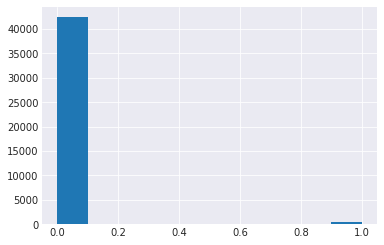

In [277]:
# explore the customer response data
plt.hist(x = mailout_train['RESPONSE'])
plt.show()

In [278]:
# number of people who are customers
mailout_train['RESPONSE'].sum()

532

In [279]:
# percentage of people who are customers
mailout_train['RESPONSE'].mean() * 100

1.2383036171500394

#### Check for columns which have many missing values

In [280]:
mailout_cols_missing = mailout_train.isnull().sum().sort_values(ascending=False)
mailout_cols_missing.head(10)

ALTER_KIND4       42921
ALTER_KIND3       42788
ALTER_KIND2       42206
ALTER_KIND1       40974
KK_KUNDENTYP      25316
EXTSEL992         15948
HH_DELTA_FLAG      9678
W_KEIT_KIND_HH     9678
KBA05_KW2          8648
MOBI_REGIO         8648
dtype: int64

In [283]:
mailout_cols_missing.describe()

count      367.000000
mean      6041.359673
std       5432.967639
min          0.000000
25%          0.000000
50%       7962.000000
75%       7962.000000
max      42921.000000
dtype: float64

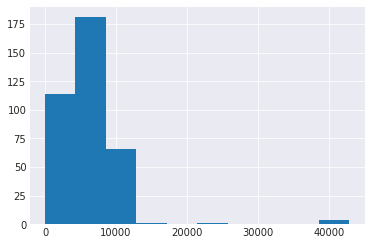

In [281]:
plt.hist(x=mailout_cols_missing, bins=10)
plt.show()

#### Check for rows which have many missing values

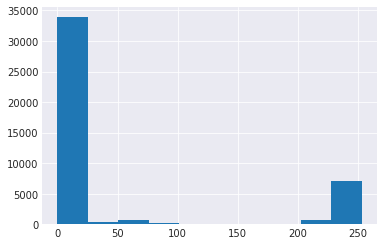

In [282]:
mailout_rows_missing = mailout_train.isnull().sum(axis=1)

plt.hist(x=mailout_rows_missing, bins=10)
plt.show()

## Data Cleaning

In [284]:
# remove columns which have more than 10k missing data
mailout_train_cleaned = mailout_train.loc[:, mailout_train.isnull().sum() < 10000]

In [286]:
mailout_train_processed = process_data(mailout_train_cleaned, unknowns)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [287]:
mailout_train_processed.shape

(42962, 726)

In [288]:
# check for any missing values
mailout_train_processed.isnull().sum().sum()

0

In [289]:
# take out the target variable column
mailout_response = mailout_train_processed.RESPONSE

In [290]:
# only use features that are common with the those that were used to train the PCA model
mailout_train_p = mailout_train_processed[common_cols]
mailout_train_p.shape

(42962, 312)

## Generate PCA components and Cluster Data

In [291]:
# scale the data first
mailout_train_scaled = pd.DataFrame(scaler.fit_transform(mailout_train_p.astype(float)))

mailout_train_scaled.columns = mailout_train_p.columns

In [292]:
%%time
# pca transform the scaled mailout_train data and generate clusters
pca_mailout_train = pca.transform(mailout_train_scaled)

mailout_train_clusters = kmeans.predict(pca_mailout_train)

CPU times: user 539 ms, sys: 187 ms, total: 726 ms
Wall time: 270 ms


In [293]:
# inspect the clusters
mailout_train_clusters

array([11,  4,  9, ...,  7,  2,  4], dtype=int32)

In [294]:
# inspection of cluster classification for top 5 observations
mailout_train_clusters_df = pd.DataFrame(mailout_train_clusters, columns=['cluster'])
mailout_train_clusters_df.head()

,cluster
0,11
1,4
2,9
3,4
4,2


In [295]:
mailout_train_clusters_df.shape

(42962, 1)

In [296]:
mailout_train_cleaned.shape

(42962, 361)

### Create a Training Set based on Previous Analysis

In the previous section, we determined the attributes of customers and non-customers by determining:
  * the clusters that have an over-representation and under-representation of customers
  * the most relevant principal components in each of those clusters
  * the most heavily weighted features and their corresponding scores
  
We have determined that the population belonging to clusters 4, 6 7 are most likely to be customers, while those belonging to clusters 1, 3 and 5 are more likely to not be customers.

Thus, we will train our data that only belong to these clusters.



In [297]:
# add the column of clusters to our cleaned dataset
mailout_train_cleaned_with_clusters = pd.concat([mailout_train_cleaned, mailout_train_clusters_df], axis=1)
mailout_train_cleaned_with_clusters.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,cluster
0,1763,2.0,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,...,2.0,1.0,6.0,9.0,3.0,3.0,0,2.0,4.0,11
1,1771,1.0,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,...,2.0,1.0,4.0,9.0,7.0,1.0,0,2.0,3.0,4
2,1776,1.0,1.0,9.0,7.0,0.0,NaN,0.0,0.0,1.0,...,4.0,2.0,NaN,9.0,2.0,3.0,0,1.0,4.0,9
3,1460,2.0,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,...,11.0,11.0,6.0,9.0,1.0,3.0,0,2.0,4.0,4
4,1783,2.0,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,...,2.0,1.0,6.0,9.0,3.0,3.0,0,1.0,3.0,2


In [298]:
# filter out data which belong only to clusters 1, 3, 7, 8
clusters = [1, 3, 7, 8]
mailout_train_valid_clusters = mailout_train_cleaned_with_clusters[mailout_train_cleaned_with_clusters.cluster.isin(clusters)]
mailout_train_valid_clusters.shape

(15599, 362)

In [299]:
mailout_train_valid_clusters.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,cluster
8,1801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,0,2.0,3.0,8
9,1834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,0,1.0,1.0,8
10,1838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,0,2.0,3.0,8
16,2216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,0,1.0,1.0,8
17,2554,NaN,1.0,8.0,8.0,1.0,0.0,0.0,1.0,1.0,...,2.0,1.0,6.0,9.0,3.0,1.0,0,1.0,4.0,7


In [300]:
mailout_train_valid_clusters_p = process_data(mailout_train_valid_clusters, unknowns)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [302]:
# save the data that we will be using for model training to a csv
mailout_train_valid_clusters_p.to_csv('analytical_base_table.csv', index=None)

## Train the Supervised Learning Model

In [304]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, auc

In [305]:
# separate out the target variable
mailout_training = mailout_train_valid_clusters_p

# isolate target variable
y = mailout_training.RESPONSE

# isolate training inputs. Drop the target variable and remove the 'clusters' column
X = mailout_training.drop(['RESPONSE', 'cluster'], axis=1)

In [306]:
# split the data into train and test sets in a 80/20 ratio. Use stratify so we have equal proportions of positive and negative classes on both the train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [307]:
# Apply 10-fold cross-validation to help us select the best model and hyperparameters

# Perform pre-processing in a model pipeline
pipelines = {
    'enet' : make_pipeline(MinMaxScaler(),
                          ElasticNet(random_state=42)),
    'rf' : make_pipeline(MinMaxScaler(),
                        RandomForestClassifier(random_state=42)),
    'gb' : make_pipeline(MinMaxScaler(),
                        GradientBoostingClassifier(random_state=42))
}

# Create hyperparameter grids to support hyperparameter tuning at a later stage
enet_hyperparams = {
    'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'elasticnet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

rf_hyperparams = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]
}

gb_hyperparams = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [1, 3, 5]
}

# hyperparameter dictionary
hyperparameters = {
    'enet': enet_hyperparams,
    'rf': rf_hyperparams,
    'gb': gb_hyperparams
}


# dictionary to store the fit models
fitted_models = {}

# perform grid search while fitting the model
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name],
                        cv=10, n_jobs=-1)
    
    model.fit(X_train, y_train)
    
    # store model in fitted_models
    fitted_models[name] = model
    
    print(f'{name} has been fitted!')

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


enet has been fitted!


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


rf has been fitted!


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/hom

gb has been fitted!


## Evaluate the Model

In [308]:
# First evaluation will be to look at the cross-validated score on the training set
for name, model in fitted_models.items():
    print(name, model.best_score_)

enet 0.0003503929715847557
rf 0.9862168442984214
gb 0.9861367096722494


In [313]:
fitted_models['gb'].best_params_

{'gradientboostingclassifier__learning_rate': 0.05,
 'gradientboostingclassifier__max_depth': 1,
 'gradientboostingclassifier__n_estimators': 100}

In [317]:
# Predict the probability of the target variable (RESPONSE) using the model that obtained the best cv score
pred = fitted_models['gb'].predict_proba(X_test)
pred = [p[1] for p in pred]

#### Area under ROC curve is the most reliable metric for classification tasks

It is equivalent to the probability that a randomly chosen Positive observation is higher than a randomly chosen Negative observation.

In other words, if you took 2 observations and exactly one of them was the positive class and the other was the negative class, what is the likelihood that the model can distinguish the two?

Hence it is the **remedy for evaluating imbalanced classes**.

##### True positive rate (TPR), False positive rate (FPR) and AUC

The TPR is the proportion of all actual positive observations that were predicted correctly as positive.

The FPR is the proportion of all actual negative observations that were predicted as positive. 

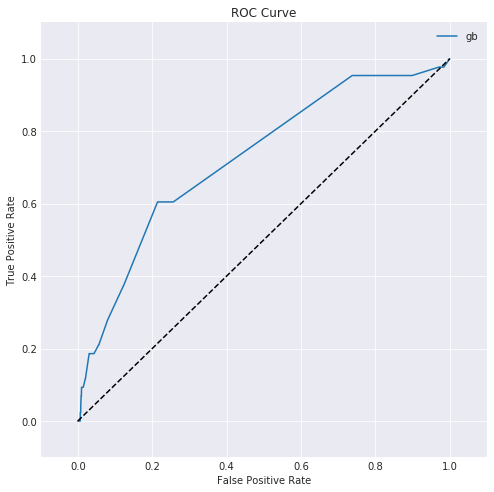

In [318]:
# Calculate the ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, pred)

# initialize figure
fig = plt.figure(figsize=(8, 8))
plt.title('ROC Curve')

# plot the ROC curve
plt.plot(fpr, tpr, label='gb')
plt.legend(loc='upper right')

# diagonal 45 degree dotted line
plt.plot([0, 1], [0, 1], 'k--')

# axes limits and labels
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [319]:
# calculate the ROC
area_under_curve = auc(fpr, tpr)
print(area_under_curve)

0.7242595097913249


In [320]:
# save the model
import pickle

with open('final_model_gb.pkl', 'wb') as f:
    pickle.dump(fitted_models['gb'].best_estimator_, f)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [321]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [322]:
lnr_id = mailout_test['LNR']

In [323]:
# pre-process the data for model prediction
mailout_test = mailout_test.loc[:, mailout_test.isnull().sum() < 10000]

mailout_test_processed = process_data(mailout_test, unknowns)

In [324]:
# pass data into model for prediction
pred_response = fitted_models['gb'].predict_proba(mailout_test_processed)

In [325]:
#retrieve the prediction probabilities
response = [p[1] for p in pred_response]

In [326]:
response_df = pd.DataFrame(response, columns=['RESPONSE'])

In [327]:
# prepare csv for submission
df = pd.concat([lnr_id, response_df], axis=1)

In [328]:
df.to_csv('arvato_submission.csv', index=None)

In [329]:
df.head()

,LNR,RESPONSE
0,1754,0.026090
1,1770,0.036093
2,1465,0.012658
3,1470,0.015277
4,1478,0.022726
